# **Finding Similar Neighboorhoods between Two Big Cities** 
Applied Data Science Capstone Project <br>
by Collins Opoku-Baah<br> 
March 20th, 2019

### Import All Necessary Libraries

In [80]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import json # library to handle JSON files

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Libraries imported.')

Libraries imported.


### Establish Credentials for The FourSquare API

In [3]:
CLIENT_ID = '0QRBYXQQQNHYFERTIUKAL2W4QKA5FLNNSHFLS3ZJBW4VODAX' # your Foursquare ID
CLIENT_SECRET = '2I3XMEMQFY5C4XBXGKUURPCMWA15AGA412EGVVYHMEPHOJNG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0QRBYXQQQNHYFERTIUKAL2W4QKA5FLNNSHFLS3ZJBW4VODAX
CLIENT_SECRET:2I3XMEMQFY5C4XBXGKUURPCMWA15AGA412EGVVYHMEPHOJNG


### Import and Clean Data for the Neighborhoods of Toronto

Get List of postal codes of Canada from Wikipedia

In [4]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')

webtable = soup.table

Postcode = []
Borough = []
Neighborhood = []

for num, tabElmt in enumerate(webtable.find_all('td')):
    
    if num%3 == 0:
        Postcode.append(tabElmt.text.rstrip())
        
    elif num%3 == 1:
        Borough.append(tabElmt.text.rstrip())
        
    elif num%3 == 2:
        Neighborhood.append(tabElmt.text.rstrip())
            

Create a Dataframe from the imported wikipedia data

In [5]:
d = {'PostalCode':Postcode, 'Borough':Borough, 'Neighborhood':Neighborhood}
newtable = pd.DataFrame(data = d)

newtable.head()

,Borough,Neighborhood,PostalCode
0,Not assigned,Not assigned,M1A
1,Not assigned,Not assigned,M2A
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A


Clean Data by taking out rows with unassigned Borough <br>
Assign the Borough name to unassigned Neighbourhoods

In [6]:
newtable.drop(index = newtable.index[newtable['Borough']=='Not assigned'], inplace = True)
newtable.reset_index(drop = True, inplace = True)

for num, i in enumerate(newtable['Neighborhood']):
    if i == 'Not assigned':
        newtable.loc[num, 'Neighborhood'] = newtable.loc[num, 'Borough']
        
newtable.head()

,Borough,Neighborhood,PostalCode
0,North York,Parkwoods,M3A
1,North York,Victoria Village,M4A
2,Downtown Toronto,Harbourfront,M5A
3,Downtown Toronto,Regent Park,M5A
4,North York,Lawrence Heights,M6A


Get Neighborhoods with Toronto in the Borough name 

In [7]:
indx = []
for i in range(newtable['Borough'].size):
    indx.append(newtable['Borough'][i].endswith('Toronto'))

# Use that list to create the new dataframe
Toronto_neigh = newtable[indx].reset_index(drop=True)

t67 = Toronto_neigh.loc[67, 'Neighborhood']
t67 = t67[t67.find('T'):]
Toronto_neigh.loc[67, 'Neighborhood'] = t67

t73 = Toronto_neigh.loc[73, 'Neighborhood']
t73 = t73[:t73.find('9')]
Toronto_neigh.loc[73, 'Neighborhood'] = t73

Toronto_neigh['Borough'] = 'Toronto'
Toronto_neigh.head()

,Borough,Neighborhood,PostalCode
0,Toronto,Harbourfront,M5A
1,Toronto,Regent Park,M5A
2,Toronto,Ryerson,M5B
3,Toronto,Garden District,M5B
4,Toronto,St. James Town,M5C


Get the shape of the Dataframe

In [8]:
Toronto_neigh.shape

(74, 3)

__Use Geocorder to get the latitude and the longitudes of all the Neighborhoods in Boroughs with Toronto in the name__

In [28]:
Toronto_cord = pd.DataFrame(columns = ['Neighborhood', 'Latitude', 'Longitude'])


for i, neigh in enumerate(Toronto_neigh['Neighborhood']):
    print(i)
    print(neigh)
    
    location = None
    counter = 0
    
    while location is None:
        counter += 1
        
        if i == 64:
            latitude = 43.777140
            longitude = -79.332610
        elif i == 73:
            latitude = 43.638080
            longitude = -79.273890    
        else: 
            address = neigh + ', Toronto, ON'
            geolocator = Nominatim(user_agent="T_explorer")
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
        
        if counter == 10:
            break 
             
    Toronto_cord = Toronto_cord.append({'Neighborhood': neigh,
                               'Latitude': latitude ,
                               'Longitude': longitude}, ignore_index = True)

Toronto_cord.head()

0
Harbourfront
1
Regent Park
2
Ryerson
3
Garden District
4
St. James Town
5
The Beaches
6
Berczy Park
7
Central Bay Street
8
Christie
9
Adelaide
10
King
11
Richmond
12
Dovercourt Village
13
Dufferin
14
Harbourfront East
15
Toronto Islands
16
Union Station
17
Little Portugal
18
Trinity
19
The Danforth West
20
Riverdale
21
Design Exchange
22
Toronto Dominion Centre
23
Brockton
24
Exhibition Place
25
Parkdale Village
26
The Beaches West
27
India Bazaar
28
Commerce Court
29
Victoria Hotel
30
Studio District
31
Lawrence Park
32
Roselawn
33
Davisville North
34
Forest Hill North
35
Forest Hill West
36
High Park
37
The Junction South
38
North Toronto West
39
The Annex
40
North Midtown
41
Yorkville
42
Parkdale
43
Roncesvalles
44
Davisville
45
Harbord
46
University of Toronto
47
Runnymede
48
Swansea
49
Moore Park
50
Summerhill East
51
Chinatown
52
Grange Park
53
Kensington Market
54
Deer Park
55
Forest Hill SE
56
Rathnelly
57
South Hill
58
Summerhill West
59
CN Tower
60
Bathurst Quay
61
Island a

,Neighborhood,Latitude,Longitude
0,Harbourfront,43.640080,-79.380150
1,Regent Park,43.660706,-79.360457
2,Ryerson,43.621573,-79.559130
3,Garden District,43.656502,-79.377128
4,St. James Town,43.669403,-79.372704


Concatenate the dataframe of Toronto neighboorhoods with that containing the Latitudes and the Longitudes

In [45]:
Toronto_data = Toronto_neigh.join(Toronto_cord[['Latitude', 'Longitude']])

Toronto_data.drop(73, axis = 0, inplace = True)   
Toronto_data

,Borough,Neighborhood,PostalCode,Latitude,Longitude
0,Toronto,Harbourfront,M5A,43.640080,-79.380150
1,Toronto,Regent Park,M5A,43.660706,-79.360457
2,Toronto,Ryerson,M5B,43.621573,-79.559130
3,Toronto,Garden District,M5B,43.656502,-79.377128
4,Toronto,St. James Town,M5C,43.669403,-79.372704
5,Toronto,The Beaches,M4E,43.671024,-79.296712
6,Toronto,Berczy Park,M5E,43.648001,-79.375385
7,Toronto,Central Bay Street,M5G,43.660920,-79.385878
8,Toronto,Christie,M6G,43.664111,-79.418405
9,Toronto,Adelaide,M5H,43.650298,-79.380477


Get the latitude and longitude of Toronto, ON

In [30]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="T_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Manhattan are 43.653963, -79.387207.


__create map of Toronto using latitude and longitude values__

In [81]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'],Toronto_data['Longitude'],Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Import and Clean Data for the Neighborhoods of New York

In [33]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

In [34]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude


In [35]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Determine the number of Neighborhoods for each Borough in New York

In [36]:
neighborhoods['Borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

Get Neighborhoods for a specified borough in New York

In [37]:
NYborough_choice = 'Queens'
NYborough_data = neighborhoods[neighborhoods['Borough'] == NYborough_choice].reset_index(drop=True)
NYborough_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


Get the coordinates for the chosen borough for New York

In [38]:
address = NYborough_choice + ', NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(NYborough_choice, latitude, longitude))

The geograpical coordinate of Queens are 40.6524927, -73.7914214158161.


In [82]:
# create map of Manhattan using latitude and longitude values
map_NYborough = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(NYborough_data['Latitude'], NYborough_data['Longitude'], NYborough_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYborough)  
    
map_NYborough

### Combine the data of the Two Cities into one DataFrame

In [46]:
Comb_data = NYborough_data.append(Toronto_data.iloc[:,[0, 1, 3, 4]], ignore_index=True)

Comb_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [47]:
print('The combined data set has {} rows and should have {} rows'. format(Comb_data.shape[0], (Toronto_data.shape[0] + NYborough_data.shape[0])))

The combined data set has 154 rows and should have 154 rows


__Use the Foursquare API to get venues around these neighborhoods__

In [48]:
def getNearbyVenues(names, borough, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, bor, lat, lng in zip(names, borough, latitudes, longitudes):
        
        print(name, bor)
        
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            bor,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Use the function above the get the venues for each of the Neighborhoods

In [49]:
LIMIT = 100
Combined_venues = getNearbyVenues(names=Comb_data['Neighborhood'],
                                  borough=Comb_data['Borough'],
                                 latitudes=Comb_data['Latitude'],
                                 longitudes=Comb_data['Longitude'])

Astoria Queens
Woodside Queens
Jackson Heights Queens
Elmhurst Queens
Howard Beach Queens
Corona Queens
Forest Hills Queens
Kew Gardens Queens
Richmond Hill Queens
Flushing Queens
Long Island City Queens
Sunnyside Queens
East Elmhurst Queens
Maspeth Queens
Ridgewood Queens
Glendale Queens
Rego Park Queens
Woodhaven Queens
Ozone Park Queens
South Ozone Park Queens
College Point Queens
Whitestone Queens
Bayside Queens
Auburndale Queens
Little Neck Queens
Douglaston Queens
Glen Oaks Queens
Bellerose Queens
Kew Gardens Hills Queens
Fresh Meadows Queens
Briarwood Queens
Jamaica Center Queens
Oakland Gardens Queens
Queens Village Queens
Hollis Queens
South Jamaica Queens
St. Albans Queens
Rochdale Queens
Springfield Gardens Queens
Cambria Heights Queens
Rosedale Queens
Far Rockaway Queens
Broad Channel Queens
Breezy Point Queens
Steinway Queens
Beechhurst Queens
Bay Terrace Queens
Edgemere Queens
Arverne Queens
Rockaway Beach Queens
Neponsit Queens
Murray Hill Queens
Floral Park Queens
Holli

Determine the shape of the resulting dataframe

In [50]:
print(Combined_venues.shape)
Combined_venues.head()

(9084, 8)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,Queens,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,Queens,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
2,Astoria,Queens,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
3,Astoria,Queens,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
4,Astoria,Queens,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym


Get the number of unique venue categories

In [51]:
print('There are {} uniques categories.'.format(len(Combined_venues['Venue Category'].unique())))

There are 380 uniques categories.


__Utilize one hot encoding to create features for the clustering__

In [52]:
# one hot encoding
Combined_onehot = pd.get_dummies(Combined_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Combined_onehot[['Neighborhood', 'Borough']] = Combined_venues[['Neighborhood', 'Borough']]

# move neighborhood column to the first column
fixed_columns = [Combined_onehot.columns[-1]] + list(Combined_onehot.columns[:-1])
Combined_onehot = Combined_onehot[fixed_columns]

Combined_onehot.head()

,Borough,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Queens,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Determine the shape of the resulting dataframe from the one hot encoding

In [53]:
Combined_onehot.shape

(9084, 381)

__Group one hot encoded dataframe by Neighborhood__

In [54]:
combined_count = Combined_onehot[['Neighborhood', 'Borough', 'Airport']].groupby(['Neighborhood',  'Borough']).count().reset_index()
combined_count.rename({'Airport':'Number of Venues'}, axis = 1, inplace = True)
combined_count.head()

,Neighborhood,Borough,Number of Venues
0,Adelaide,Toronto,100
1,Arverne,Queens,23
2,Astoria,Queens,100
3,Astoria Heights,Queens,40
4,Auburndale,Queens,66


In [55]:
meannum = combined_count.groupby('Borough').mean()
stdnum = combined_count.groupby('Borough').std().reset_index()
meannum.rename({'Number of Venues':'Mean Number of Venues'}, axis = 1, inplace = True)
meannum

,Mean Number of Venues
Borough,
Queens,46.851852
Toronto,73.458333


__plot the mean number of venues__

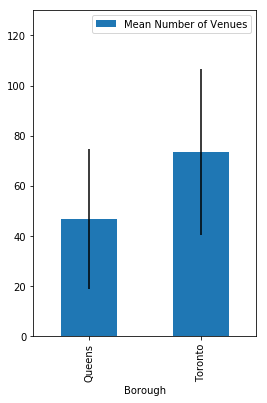

In [56]:
meannum.plot(kind = 'bar', figsize=(4, 6), yerr = stdnum.iloc[:,1].values)
plt.ylim(0, 130)
plt.legend()
plt.show()

__Group one hot encoded dataframe by Neighborhood__

In [58]:
Combined_grouped = Combined_onehot.groupby(['Neighborhood', 'Borough']).mean().reset_index()
Combined_grouped.head()

,Neighborhood,Borough,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Adelaide,Toronto,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.00,0.000000,0.01,0.0,0.0,0.0
1,Arverne,Queens,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0
2,Astoria,Queens,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.01,0.000000,0.00,0.0,0.0,0.0
3,Astoria Heights,Queens,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0
4,Auburndale,Queens,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.015152,0.00,0.0,0.0,0.0


In [59]:
Combined_grouped.shape

(153, 381)

__Determine the first number of most common venues for each of the big cities__

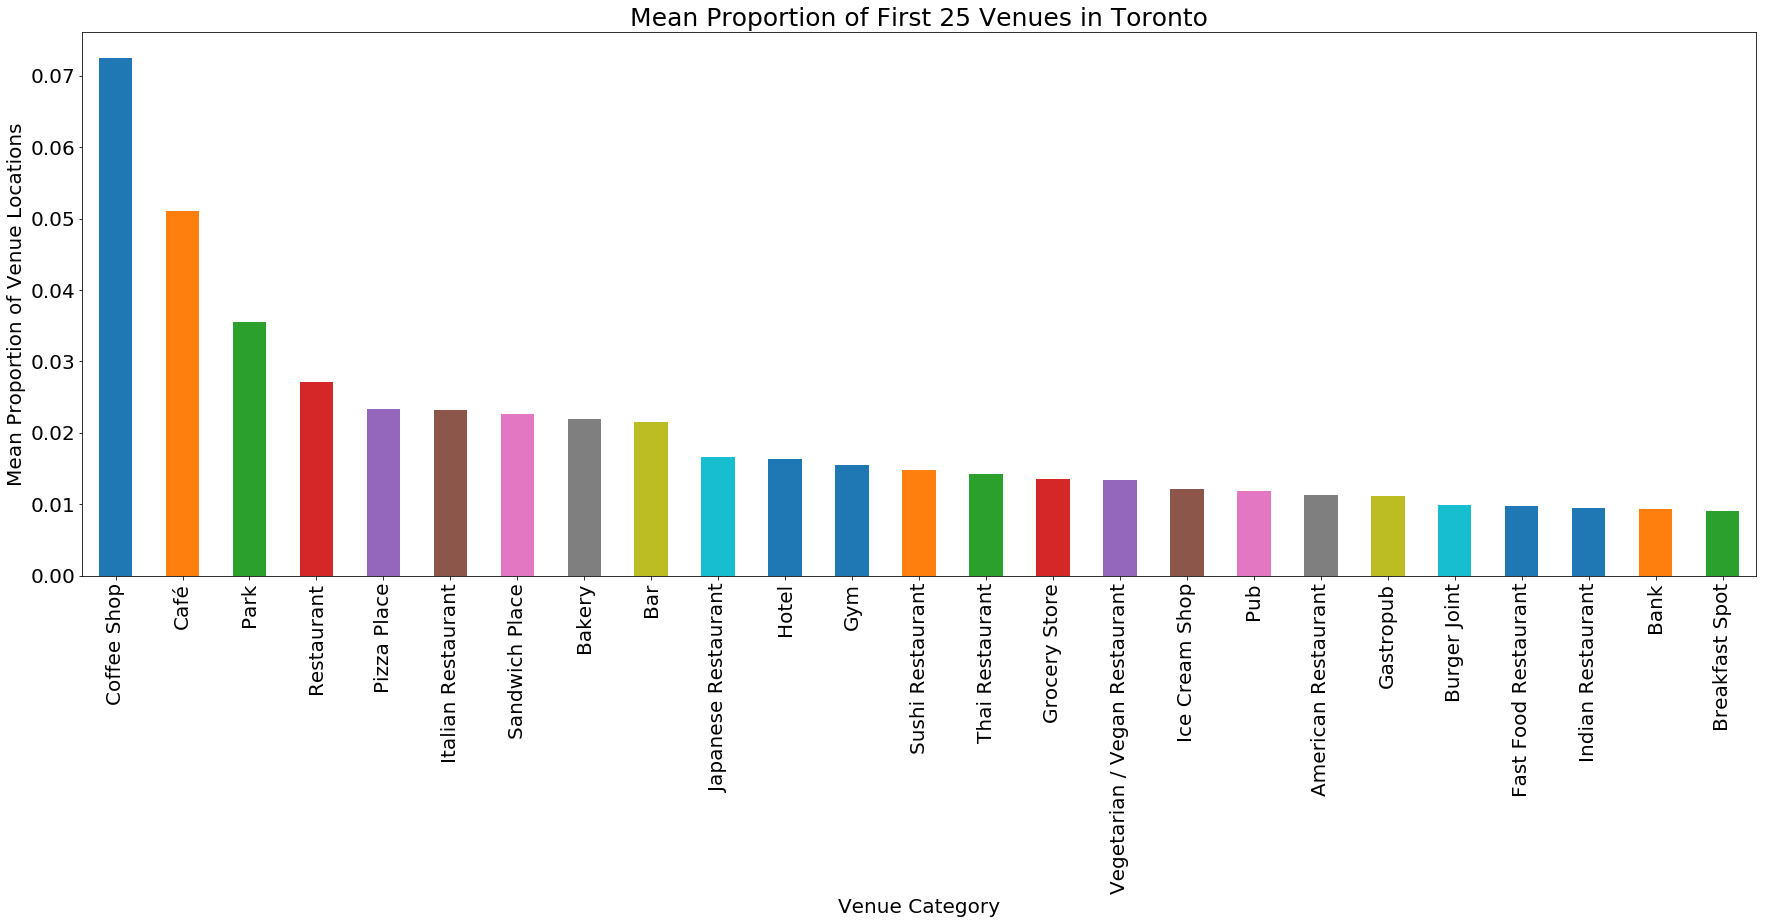

In [60]:
numcomb = 25
combined_Toronto_common = Combined_grouped.loc[Combined_grouped['Borough']=='Toronto'].mean(axis=0)
comb_Toronto = combined_Toronto_common.sort_values(ascending = False)[0:numcomb]

comb_Toronto.plot(kind = 'bar', figsize=(30,10), fontsize = 20)
plt.xlabel('Venue Category', fontsize = 20)
plt.ylabel('Mean Proportion of Venue Locations', fontsize = 20)
plt.title('Mean Proportion of First 25 Venues in Toronto', fontsize = 25)
plt.show()

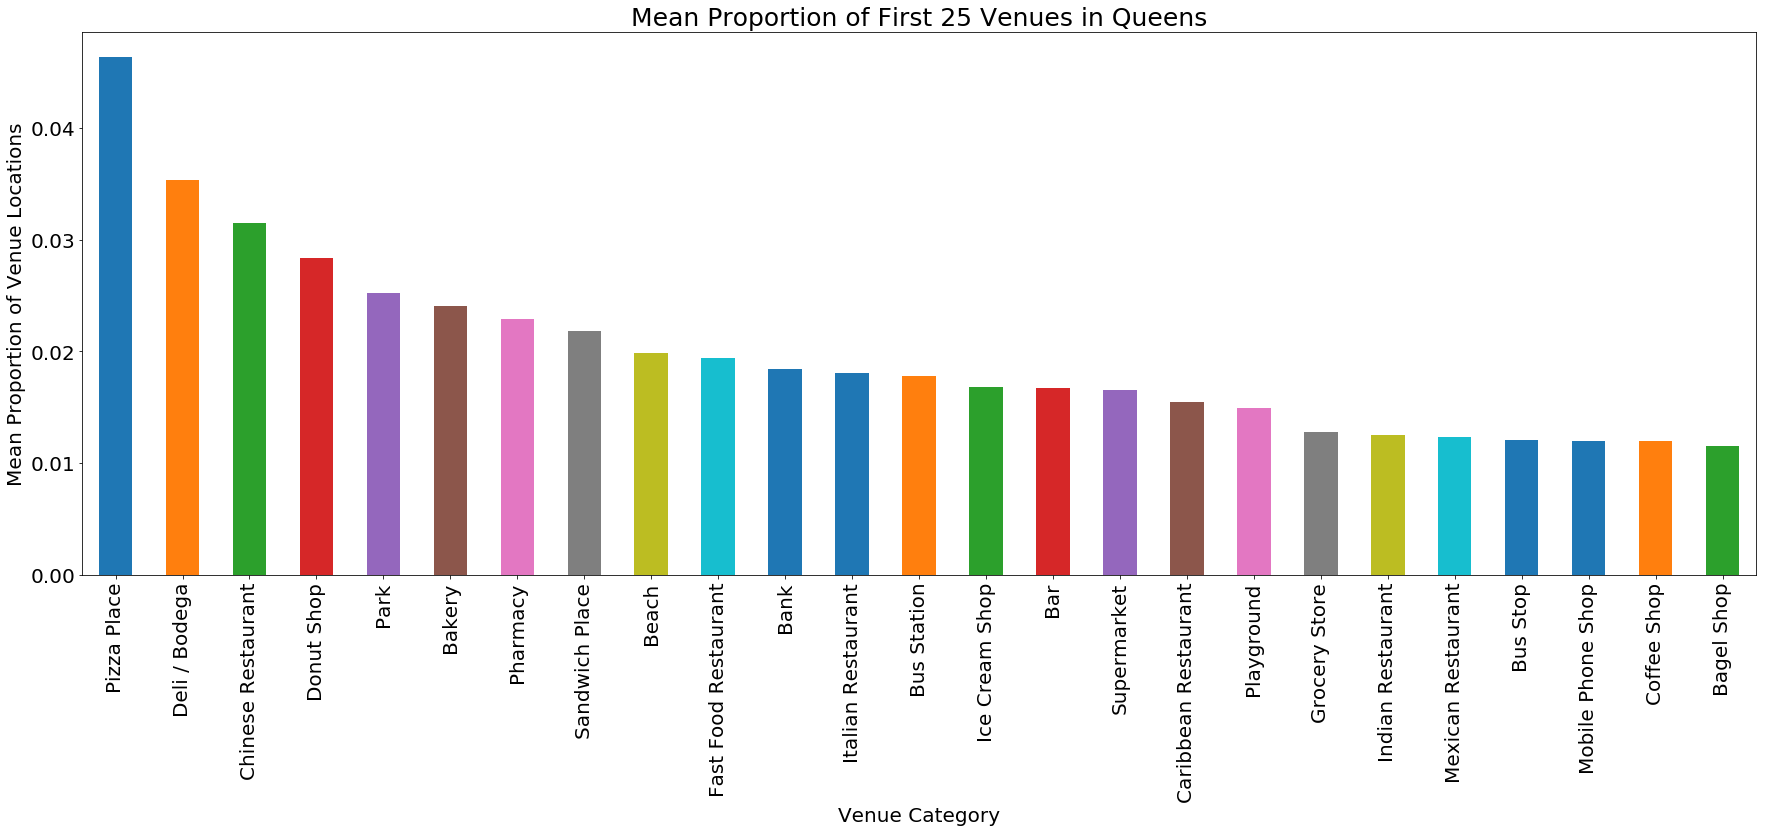

In [62]:
combined_NYborough_common = Combined_grouped.loc[Combined_grouped['Borough']==NYborough_choice].mean(axis=0)
comb_NYborough = combined_NYborough_common.sort_values(ascending = False)[0:numcomb]

comb_NYborough.plot(kind = 'bar', figsize=(30,10), fontsize = 20)
plt.xlabel('Venue Category', fontsize = 20)
plt.ylabel('Mean Proportion of Venue Locations', fontsize = 20)
plt.title('Mean Proportion of First 25 Venues in Queens', fontsize = 25)
plt.show()

__Use this function to return the most common venues for each Neighborhood__

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood', 'Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Combined_venues_sorted = pd.DataFrame(columns=columns)
Combined_venues_sorted[['Neighborhood', 'Borough']] = Combined_grouped[['Neighborhood', 'Borough']]

for ind in np.arange(Combined_grouped.shape[0]):
    Combined_venues_sorted.iloc[ind, 2:] = return_most_common_venues(Combined_grouped.iloc[ind, :], num_top_venues)

Combined_venues_sorted.head()

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Toronto,Coffee Shop,Hotel,Café,Restaurant,Gastropub,Japanese Restaurant,Gym,American Restaurant,Bakery,Italian Restaurant
1,Arverne,Queens,Surf Spot,Bus Stop,Metro Station,Thai Restaurant,Harbor / Marina,Bank,Donut Shop,Sandwich Place,Beach,Supermarket
2,Astoria,Queens,Bar,Bakery,Greek Restaurant,Hookah Bar,Middle Eastern Restaurant,Grocery Store,Seafood Restaurant,Coffee Shop,Pizza Place,Italian Restaurant
3,Astoria Heights,Queens,Rental Car Location,Bus Station,Italian Restaurant,Deli / Bodega,Pizza Place,Bakery,Airport Terminal,Plaza,Baseball Field,Gourmet Shop
4,Auburndale,Queens,Korean Restaurant,Pizza Place,Café,Cosmetics Shop,Greek Restaurant,Pharmacy,American Restaurant,Donut Shop,Deli / Bodega,Juice Bar


### Clustering the Neighborhoods

In [66]:
# set number of clusters
Combined_grouped_clustering = Combined_grouped.drop(['Neighborhood', 'Borough'], 1)
Inertia = []
allclusters = np.arange(2, 10)

for kclusters in allclusters:
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(Combined_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    
    #inert = metrics.silhouette_score(Combined_grouped_clustering, kmeans.labels_, metric='euclidean')
    #inert = metrics.calinski_harabaz_score(Combined_grouped_clustering, kmeans.labels_)
    Inertia.append(kmeans.inertia_)
    

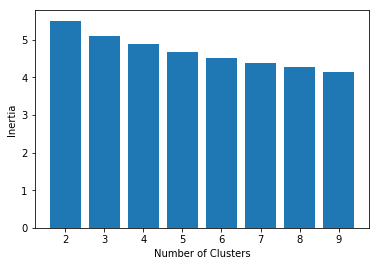

In [68]:
plt.bar(allclusters, Inertia)
plt.xticks(allclusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

__run k-means clustering for chosen number of clusters__

In [70]:
kmeans = KMeans(n_clusters=9, random_state=4).fit(Combined_grouped_clustering)

__Merge Original Data and Cluster Labels__

In [71]:
# add clustering labels
Combined_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Combined_venues_sorted.drop(['Borough'], 1, inplace = True)

Combined_merged = Comb_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Combined_merged = Combined_merged.join(Combined_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [72]:
Combined_merged.sort_values('Cluster Labels', inplace = True) # check the last columns!
Combined_merged = Combined_merged.reset_index(drop=True)
Combined_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,Underground city,43.770145,-79.374863,0,Furniture / Home Store,Moving Target,Coffee Shop,Park,Hot Dog Joint,Chinese Restaurant,Fish Market,Breakfast Spot,Sporting Goods Shop,Metro Station
1,Queens,Jamaica Hills,40.711460,-73.796465,0,Pharmacy,Donut Shop,Indian Restaurant,Clothing Store,Department Store,Shoe Store,Mobile Phone Shop,Southern / Soul Food Restaurant,Caribbean Restaurant,Fried Chicken Joint
2,Queens,Hollis,40.711243,-73.759250,0,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Lounge,Bus Stop,Grocery Store,Chinese Restaurant,Train Station,Restaurant,Supermarket
3,Toronto,Trinity,43.654676,-79.381731,0,Coffee Shop,Clothing Store,Cosmetics Shop,Restaurant,Tea Room,Café,American Restaurant,Seafood Restaurant,Steakhouse,Italian Restaurant
4,Toronto,Railway Lands,43.777140,-79.332610,0,Middle Eastern Restaurant,Supermarket,Chinese Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,Clothing Store,Gym,Deli / Bodega,Baseball Field


### Examine Clusters

____Determine the Number of Neighborhoods in each cluster grouped by the name of the city__

In [73]:
ClusterSum = Combined_merged[['Neighborhood', 'Borough', 'Cluster Labels']].groupby(['Cluster Labels', 'Borough']).count().reset_index()

ClusterSum

,Cluster Labels,Borough,Neighborhood
0,0,Queens,6
1,0,Toronto,5
2,1,Queens,3
3,1,Toronto,56
4,2,Queens,1
5,3,Queens,51
6,3,Toronto,1
7,4,Queens,4
8,5,Queens,9
9,5,Toronto,1


__Create a figure for Number of Neighborhoods Grouped by Cluster Type and City__

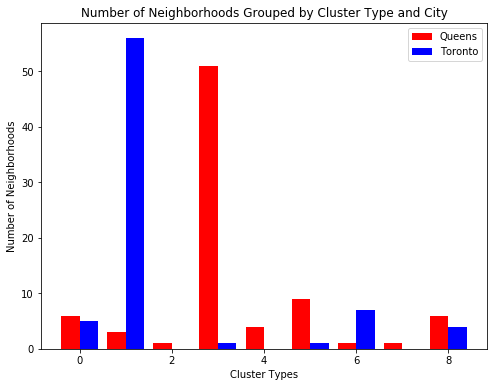

In [74]:
fig, ax = plt.subplots(figsize = (8, 6))
bar_width = 0.4

x_queens = ClusterSum[ClusterSum['Borough']=='Queens']['Cluster Labels'].values
y_queens =  ClusterSum[ClusterSum['Borough']=='Queens']['Neighborhood'].values

x_toronto = ClusterSum[ClusterSum['Borough']=='Toronto']['Cluster Labels'].values
y_toronto =  ClusterSum[ClusterSum['Borough']=='Toronto']['Neighborhood'].values

ax.bar(x_queens-(bar_width/2), y_queens, width = bar_width, color = 'r')
ax.bar(x_toronto+(bar_width/2), y_toronto, width = bar_width, color = 'b')

ax.set_xlabel('Cluster Types', fontsize = 10)
ax.set_ylabel('Number of Neighborhoods', fontsize = 10)
ax.set_title('Number of Neighborhoods Grouped by Cluster Type and City', fontsize = 12)
ax.legend(['Queens', 'Toronto'])

plt.show()

__Combine and analyze the First Most Common Venue Locations for Each Cluster Type__

In [76]:
ClusterCommon = pd.get_dummies(Combined_merged.iloc[:, [5]], prefix="", prefix_sep="")

ClusterCommon[['Cluster Labels', 'Borough']] = Combined_merged[['Cluster Labels', 'Borough']]

ClusterComGrp = ClusterCommon.groupby(['Cluster Labels']).mean().reset_index()
ClusterComGrp

,Cluster Labels,Airport Terminal,Bakery,Bank,Bar,Beach,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,...,Rental Car Location,Restaurant,Sandwich Place,Surf Spot,Sushi Restaurant,Thai Restaurant,Theater,Theme Park,Trail,Vietnamese Restaurant
0,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.090909,0.000000,0.363636,...,0.000000,0.000000,0.090909,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,1,0.0,0.016949,0.000000,0.067797,0.0,0.135593,0.000000,0.000000,0.000000,...,0.000000,0.016949,0.033898,0.0,0.000000,0.000000,0.0,0.0,0.0,0.016949
2,2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,3,0.0,0.096154,0.019231,0.076923,0.0,0.000000,0.000000,0.096154,0.000000,...,0.019231,0.000000,0.000000,0.0,0.019231,0.038462,0.0,0.0,0.0,0.000000
4,4,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
5,5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.100000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
6,6,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
7,7,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
8,8,0.1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.1,0.1,0.2,0.000000


__Create a figure for the First and Second Most Common Venue Locations for Each Cluster Type__

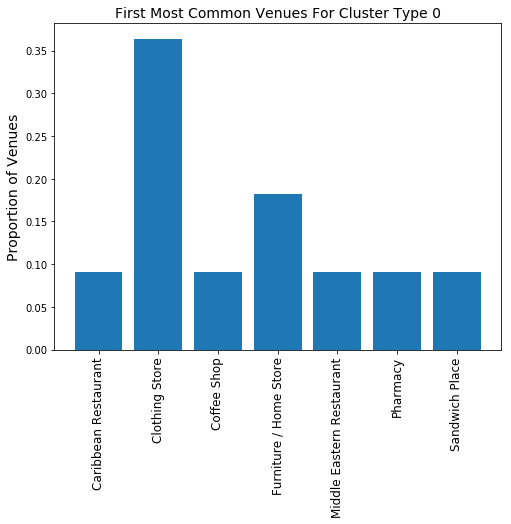

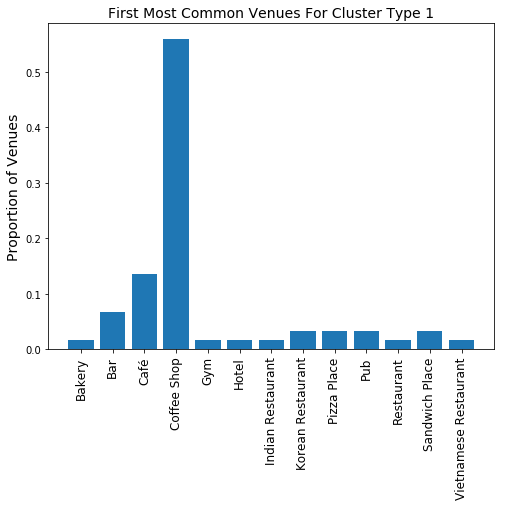

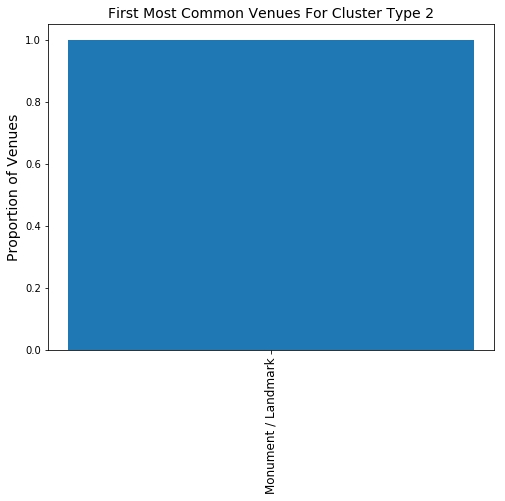

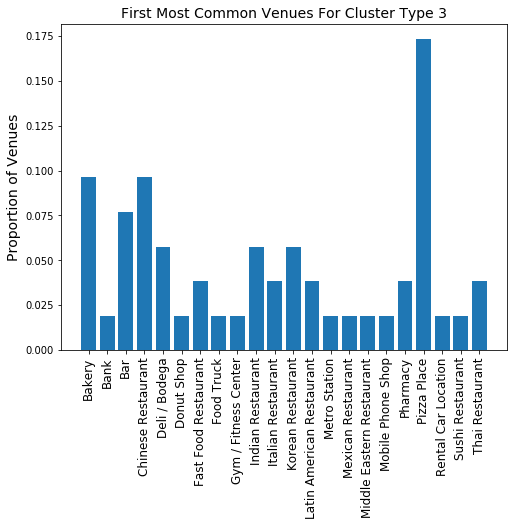

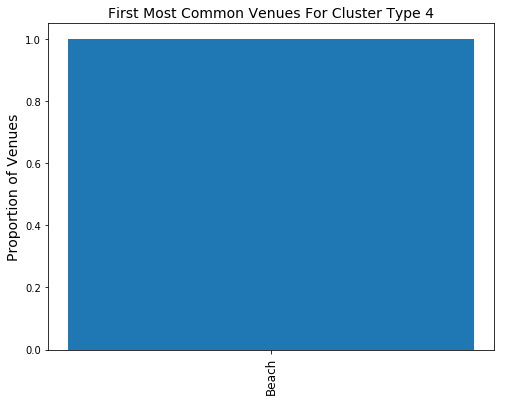

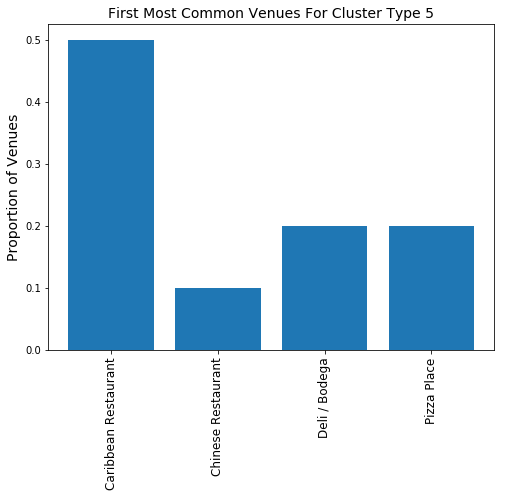

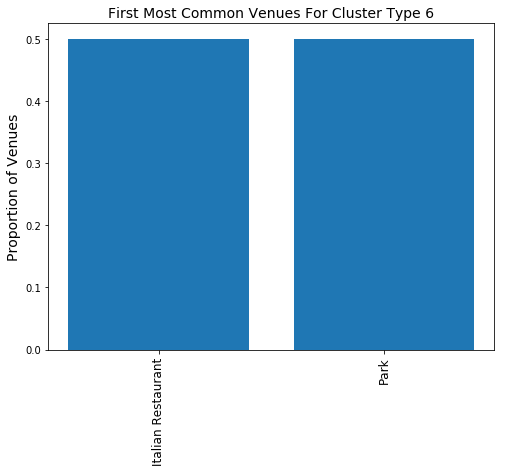

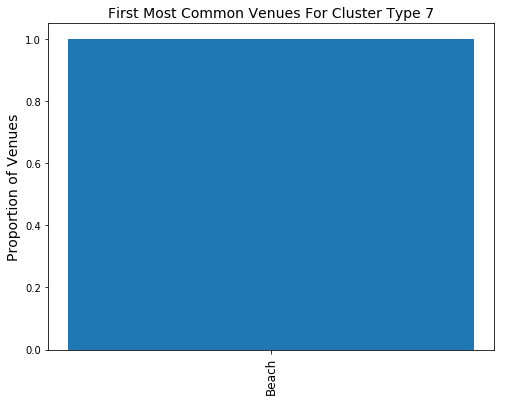

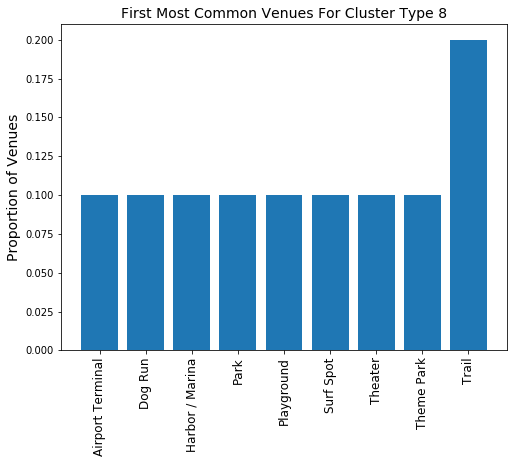

In [83]:
for i in np.arange(9):

    k = ClusterComGrp.loc[ClusterComGrp['Cluster Labels']==i, ClusterComGrp.columns[1]:ClusterComGrp.columns[-1]]
    kk = k.iloc[:, np.nonzero(k.values)[1]]
    kk.sort_values(i, axis = 1, ascending = False)

    fig, ax = plt.subplots(figsize = (8,6))
    ax.bar(np.arange(kk.shape[1]), kk.iloc[0, :].values, width = 0.8)
    ax.set_xticks(np.arange(kk.shape[1]))
    ax.set_xticklabels(kk.columns, fontdict = {'fontsize': 12}, rotation = 90)
    ax.set_ylabel('Proportion of Venues', fontsize = 14)
    ax.set_title('First Most Common Venues For Cluster Type {}'.format(i), fontsize = 14)
    plt.show()


__Get the Neighboorhoods for Each City in the Cluster Types__

In [78]:
ClusterNeigh = Combined_merged[['Neighborhood', 'Borough', 'Cluster Labels']]

for i in np.arange(9):
    ClusterNeigh_T = ClusterNeigh[ClusterNeigh['Cluster Labels']==i].sort_values(by='Borough').reset_index(drop=True)
    print('Cluster Type {}'.format(i))
    print(ClusterNeigh_T)
    '/n'


Cluster Type 0
        Neighborhood  Borough  Cluster Labels
0      Jamaica Hills   Queens               0
1             Hollis   Queens               0
2     Jamaica Center   Queens               0
3        Bay Terrace   Queens               0
4        Lefrak City   Queens               0
5           Glendale   Queens               0
6   Underground city  Toronto               0
7            Trinity  Toronto               0
8      Railway Lands  Toronto               0
9            Ryerson  Toronto               0
10   Garden District  Toronto               0
Cluster Type 1
               Neighborhood  Borough  Cluster Labels
0          Long Island City   Queens               1
1              Queensbridge   Queens               1
2             Hunters Point   Queens               1
3      Church and Wellesley  Toronto               1
4                  CN Tower  Toronto               1
5                 Chinatown  Toronto               1
6             Bathurst Quay  Toronto           